# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains 10 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

## Section 1: Preparing the vocabulary

In [11]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [19]:
# Function to load and process the text file
def load_and_process_words(file_path):
    vocab = []
    
    with open(file_path, 'r') as file:
        # Read each word from the file
        words = file.read().splitlines()
        
        # Process each word
        for word in words:
            word = word.lower()  # Convert to lowercase
            
            # Filter words with length between 4 and WORD_SIZE (inclusive)
            if 3 < len(word) <= WORD_SIZE:
                # If word is shorter than WORD_SIZE, pad with underscores
                word = word.ljust(WORD_SIZE, '_')
                vocab.append(word)
    
    return vocab

file_path = 'wordlist.txt'
vocab = load_and_process_words(file_path)
print('Number of words in vocabulary:', len(vocab))
# Print 20 random words from the vocabulary
random_words = random.sample(vocab, 20)
print(random_words)


Number of words in vocabulary: 8847
['mozilla______', 'jones________', 'enables______', 'editions_____', 'servers______', 'name_________', 'trusts_______', 'central______', 'fruits_______', 'global_______', 'numerical____', 'conventional_', 'remainder____', 'source_______', 'jessica______', 'anti_________', 'favorite_____', 'historic_____', 'advanced_____', 'introduced___']


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer** (to write answers edit this cell)

Words shorter than 4 letters are often less informative and by removing these short words we can reduce the dimensionality of the input space, making the model more efficient and helping it focus on more meaningful, content-rich words.

Sequence-based tasks often expect input sequences to have uniform dimensions to simplify matrix operations for efficient processing. Padding words to a fixed length of 13 ensures that the model deals with a fixed input size, which allows for efficient use of memory, better generalization and stability.

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [13]:
# (i) Convert character to a number
def char_to_num(char):
    if char == '_':
        return 0
    else:
        return ord(char) - ord('a') + 1

# (ii) Convert number to character
def num_to_char(num):
    if num == 0:
        return '_'
    else:
        return chr(num + ord('a') - 1)

# (iii) Convert a word to a list of numbers (tensor)
def word_to_numlist(word):
    numlist = [char_to_num(char) for char in word]  # Convert each character in the word
    return torch.tensor(numlist, dtype=torch.long)  # Convert the list to a torch tensor

# (iv) Convert a list of numbers (tensor) back to a word
def numlist_to_word(numlist):
    chars = [num_to_char(num.item()) for num in numlist]  # Convert each number back to a character
    return ''.join(chars)  # Join the characters back into a string

word = "united_______"
numlist = word_to_numlist(word)
print("Word to numlist:", numlist)

reconstructed_word = numlist_to_word(numlist)
print("Numlist to word:", reconstructed_word)

Word to numlist: tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0])
Numlist to word: united_______


<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

**Answer** (to write answers edit this cell)

An ordinal relationship is introduced when we assign numbers to letters based on their alphabetical order that doesn’t actually exist between letters. For instance, the difference between b and c is treated as the same as the difference between a and b, which may imply some kind of linear relationship. Further, the distance between a (1) and z (26) is far greater than the distance between a (1) and b (2). This implies that a and z are very different, which might not always be true in the context of word prediction. In addition a loss of Contextual and positional information is also possible.

An Embedding Layer is a part of machine learning models that allows the processing and reduction of high-dimensional categorical data into a lower-dimensional space. The purpose of an embedding layer is to transform categorical data (like letters or words) into dense vectors in a continuous vector space, where relationships between the data can be learned and represented in a meaningful way.

An embedding layer takes sparse inputs (like numbers representing letters) and converts them into dense, low-dimensional vectors. For example, instead of representing "a" as 1, "b" as 2, etc., the embedding layer will learn to represent each letter or word as a vector of numbers, such as [0.1, 0.2, -0.3] for one letter. During training, the embedding layer adjusts these vector representations so that similar entities are closer together in this learned space. Unlike raw numerical encoding, embedding layers do not impose any ordinal structure on the data. The embedding vectors are learned from data in a way that captures patterns and relationships without assuming an inherent numerical order.

Embedding layers also allow for dimensionality reduction. Instead of representing a large vocabulary (or alphabet) as sparse one-hot vectors or numbers, an embedding layer can map them into a much smaller-dimensional space, making the computation more efficient.



## Section 2: Implementing the Autocomplete model

We will implement a RNN model based on LSTM. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [14]:
LEARNING_RATE = 0.005

In [18]:
class autocompleteModel(nn.Module):

    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers, device):
        super().__init__()

        self.device = device  # Device to use (CPU or GPU)
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Initialize the layers in the model
        self.embedding = nn.Embedding(alphabet_size, embed_dim).to(self.device)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers).to(self.device)
        self.fc = nn.Linear(hidden_size, alphabet_size).to(self.device)

    def forward(self, character, hidden_state, cell_state):
        embedded = self.embedding(character).to(self.device)
        lstm_out, (hidden_state, cell_state) = self.lstm(embedded.view(1, 1, -1), (hidden_state, cell_state))
        output = self.fc(lstm_out.view(1, -1))
        return output, hidden_state, cell_state

    def initial_state(self):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
        return (h0, c0)

    def trainModel(self, vocab, epochs=5, batch_size=100, learning_rate=0.005):
        self.train()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss().to(self.device)
        
        # Log for tracking batch-wise loss
        batch_loss_log = []

        # Iterate over epochs
        for e in range(epochs):
            random.shuffle(vocab)

            # Iterate over the vocabulary in batches
            for i in range(0, len(vocab), batch_size):
                vocab_batch = vocab[i:i + batch_size]
                optimizer.zero_grad()
                batch_loss = 0

                # Iterate over each word in the batch
                for word in vocab_batch:
                    hidden_state, cell_state = self.initial_state()
                    word_tensor = word_to_numlist(word).to(self.device)  # Move word tensor to device

                    # Input characters are all characters except the last
                    input_chars = word_tensor[:-1]
                    # Target characters are the characters following the input characters
                    target_chars = word_tensor[1:]

                    for c in range(WORD_SIZE - 1):
                        input_char = input_chars[c].unsqueeze(0).to(self.device)
                        target_char = target_chars[c].unsqueeze(0).to(self.device)

                        # Forward pass
                        output, hidden_state, cell_state = self.forward(input_char, hidden_state, cell_state)
                        
                        # Calculate loss
                        loss = criterion(output, target_char)
                        batch_loss += loss

                # Normalize batch loss
                batch_loss /= len(vocab_batch)
                batch_loss.backward()
                optimizer.step()

                # Log batch loss
                batch_loss_log.append(batch_loss.item())

            print(f"Epoch {e+1}, Loss: {batch_loss.item()}")

        # Plot batch-wise loss
        plt.plot(batch_loss_log)
        plt.xlabel("Batch Iteration")
        plt.ylabel("Loss")
        plt.title("Batch-wise Training Loss")
        plt.show()

        return batch_loss_log


    def autocomplete(self, sample):
        self.eval()
        completed_list = []

        for literal in sample:
            padded_literal = literal.ljust(WORD_SIZE, '_')
            input_tensor = word_to_numlist(padded_literal).to(self.device)

            hidden_state, cell_state = self.initial_state()
            predicted_word = literal

            for i in range(len(literal)):
                input_char = input_tensor[i].unsqueeze(0).to(self.device)
                output, hidden_state, cell_state = self.forward(input_char, hidden_state, cell_state)

            for i in range(len(literal), WORD_SIZE):
                probabilities = torch.softmax(output, dim=1)
                predicted_char = torch.multinomial(probabilities, 1).item()
                predicted_word += num_to_char(predicted_char)

                input_char = torch.tensor([predicted_char]).unsqueeze(0).to(self.device)
                output, hidden_state, cell_state = self.forward(input_char, hidden_state, cell_state)

            completed_list.append(predicted_word)

        return completed_list




## Section 3: Using and evaluating the model

(i) Feel free to initialize a autocompleteModel using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can. Show the loss curves in you answers.

(ii) Evaluate it on different samples of partially filled in words. Eg: ["univ", "math", "neur", "engin"] etc. Please show outputs for different samples.

<font color='blue'>Comment on the results. Is it successful? Do you see familiar substrings in the generated tesxt such as "tion", "ing", "able" etc. What are your suggestions to improve the model?</font>

**Answer** (to write answers edit this cell)

The model is mostly successful. Yes very common substrings and suffixes were predicted to given text. 

To improve,
A larger and more diverse training dataset could be used to expose the model to a greater variety of word patterns.
Using larger embedding dimensions to allow the model to capture more intricate relationships.
Increasing the hidden size or adding additional layers or use a different architecture.


Device: cuda
model initialized
Epoch 1, Loss: 23.38127899169922
Epoch 2, Loss: 19.016632080078125
Epoch 3, Loss: 18.157270431518555
Epoch 4, Loss: 17.34376335144043
Epoch 5, Loss: 15.696905136108398


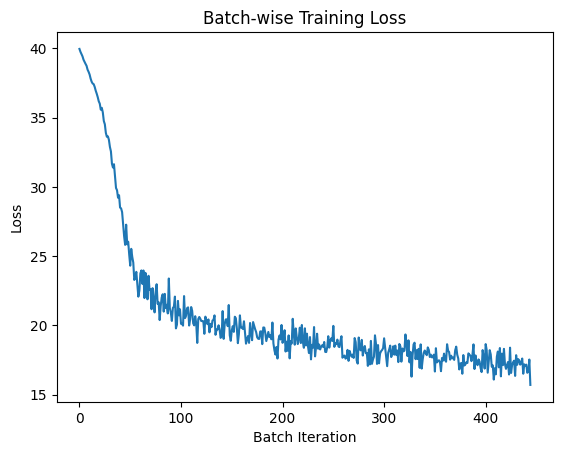

training completed


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Initialize the model
model = autocompleteModel(alphabet_size=27, embed_dim=16, hidden_size=32, num_layers=1, device=device)
print("model initialized")

# # Train the model using the vocab
model.trainModel(vocab, epochs=5, batch_size=100)
print("training completed")

In [31]:
# Test the model
def test_model(model):
    """
    This function tests the autocomplete model using a predefined sample of words.
    
    Parameters:
        model: The trained autocomplete model.
    
    Returns:
        None
    """
    
    # Example 50-word sample input list for inference
    sample = [
        "univ", "math", "neur", "engin", "tran", "explor", "creat", "devel", "solut", "commu",
        "inno", "navig", "advent", "analy", "opti", "net", "vis", "tranquil", "experi", "futur",
        "connec", "myst", "inter", "comput", "const", "gener", "innov", "system", "quant", "tech",
        "biolog", "synth", "artif", "medic", "inform", "theor", "physic", "chem", "astro", "micro",
        "macro", "probab", "struct", "bioeng", "transf", "algor", "neuro", "cognit", "planet", "eco"
    ]

    # Assuming model.autocomplete returns a list of completed words
    completed_words = model.autocomplete(sample)

    # Combine input words and predictions into a DataFrame
    data = {
        'Input Word': sample,
        'Prediction': completed_words
    }

    # Create a DataFrame from the combined data
    results_df = pd.DataFrame(data)

    # Reshape DataFrame to have 5 columns with 10 rows each
    num_rows = 10
    num_columns = 5
    reshaped_data = []

    # Fill the reshaped_data with pairs of input and predictions
    for i in range(num_rows):
        row_data = []
        for j in range(num_columns):
            idx = i + j * num_rows
            if idx < len(results_df):
                row_data.append(f"{results_df['Input Word'].iloc[idx]} -> {results_df['Prediction'].iloc[idx]}")
            else:
                row_data.append("")  # Handle cases where there are not enough words
        reshaped_data.append(row_data)

    # Create a new DataFrame from the reshaped data
    final_df = pd.DataFrame(reshaped_data, columns=[f'Column {i+1}' for i in range(num_columns)])

    # Display the final DataFrame
    display(final_df.style.set_properties(**{'text-align': 'left'}))



In [32]:
# Test the model on 50 words
test_model(model)

,Column 1,Column 2,Column 3,Column 4,Column 5
0,univ -> univuinon____,inno -> innonrode____,connec -> connecrmtitat,biolog -> biologiont___,macro -> macrouniox___
1,math -> mathironm____,navig -> navig________,myst -> mystesiow____,synth -> synthutiol___,probab -> probabes_____
2,neur -> neurin_______,advent -> advente______,inter -> inter________,artif -> artifivs_____,struct -> structiom____
3,engin -> enginlettsl__,analy -> analy________,comput -> computed_____,medic -> medicenm_____,bioeng -> bioeng_______
4,tran -> trandeled____,opti -> optiice______,const -> constatehan__,inform -> inform_______,transf -> transfetc____
5,explor -> explora______,net -> netxoga______,gener -> genergede____,theor -> theor________,algor -> algorc_______
6,creat -> creatum______,vis -> vismimp______,innov -> innovs_______,physic -> physic_______,neuro -> neurorar_____
7,devel -> devellie_____,tranquil -> tranquilen___,system -> systemiv_____,chem -> chemocanes___,cognit -> cognit_______
8,solut -> solut________,experi -> experini_____,quant -> quante_______,astro -> astrotc______,planet -> planet_______
9,commu -> commuertar___,futur -> futuri_______,tech -> techars______,micro -> microat______,eco -> econgur______


In [ ]:
print("Initializing model with embed_dim=64, hidden_size=128, num_layers=1...")
model_1 = autocompleteModel(alphabet_size=27, embed_dim=64, hidden_size=128, num_layers=1, device=device)
print("Model 1 initialized.")
loss_log_1 = model_1.trainModel(vocab, epochs=10, batch_size=100)
print("Training for Model 1 completed.")

Initializing model with embed_dim=64, hidden_size=128, num_layers=1...
Model 1 initialized.


In [6]:
# Test the model on 50 words
test_model(model_1)

NameError: name 'model' is not defined

In [16]:

# Initialize the second model
print("Initializing model with embed_dim=128, hidden_size=256, num_layers=2...")
model_2 = autocompleteModel(alphabet_size=27, embed_dim=128, hidden_size=256, num_layers=2, device=device)
print("Model 2 initialized.")
loss_log_2 = model_2.trainModel(vocab, epochs=15, batch_size=100)
print("Training for Model 2 completed.")

Device: cuda
autocompleteModel(
  (embedding): Embedding(27, 64)
  (lstm): LSTM(64, 128, num_layers=2)
  (fc): Linear(in_features=128, out_features=27, bias=True)
)
Epoch 1, Loss: 16.277488708496094
Epoch 2, Loss: 14.185486793518066
Epoch 3, Loss: 13.017935752868652
Epoch 4, Loss: 12.039627075195312
Epoch 5, Loss: 11.655515670776367
Epoch 6, Loss: 11.62802791595459


KeyboardInterrupt: 

In [ ]:
# Test the model on 50 words
test_model(model_2)